# Housing prices

I use publicly available data on housing prices to build linear, polynomial, and ranfom forest regression models to predict prices, and use outlier detection to pick out unusual cases.

In [108]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from matplotlib import rcParams

## Exploring the data

This dataset contains information about 506 houses in a suburb of Boston, and contains information about the number of rooms, per capita crime rate by town, pollution, etc (13 features total). The housing prices (MEDV- the median value of owner-occupied homes in $1000s) will be our target variable.

In [26]:
bos = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                 header=None, sep='\s+')
bos.columns = ['CRIM', 'ZN', 'INDUS','CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO',
                 'B', 'LSTAT', 'MEDV']
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [27]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### View pairwise plots between different features

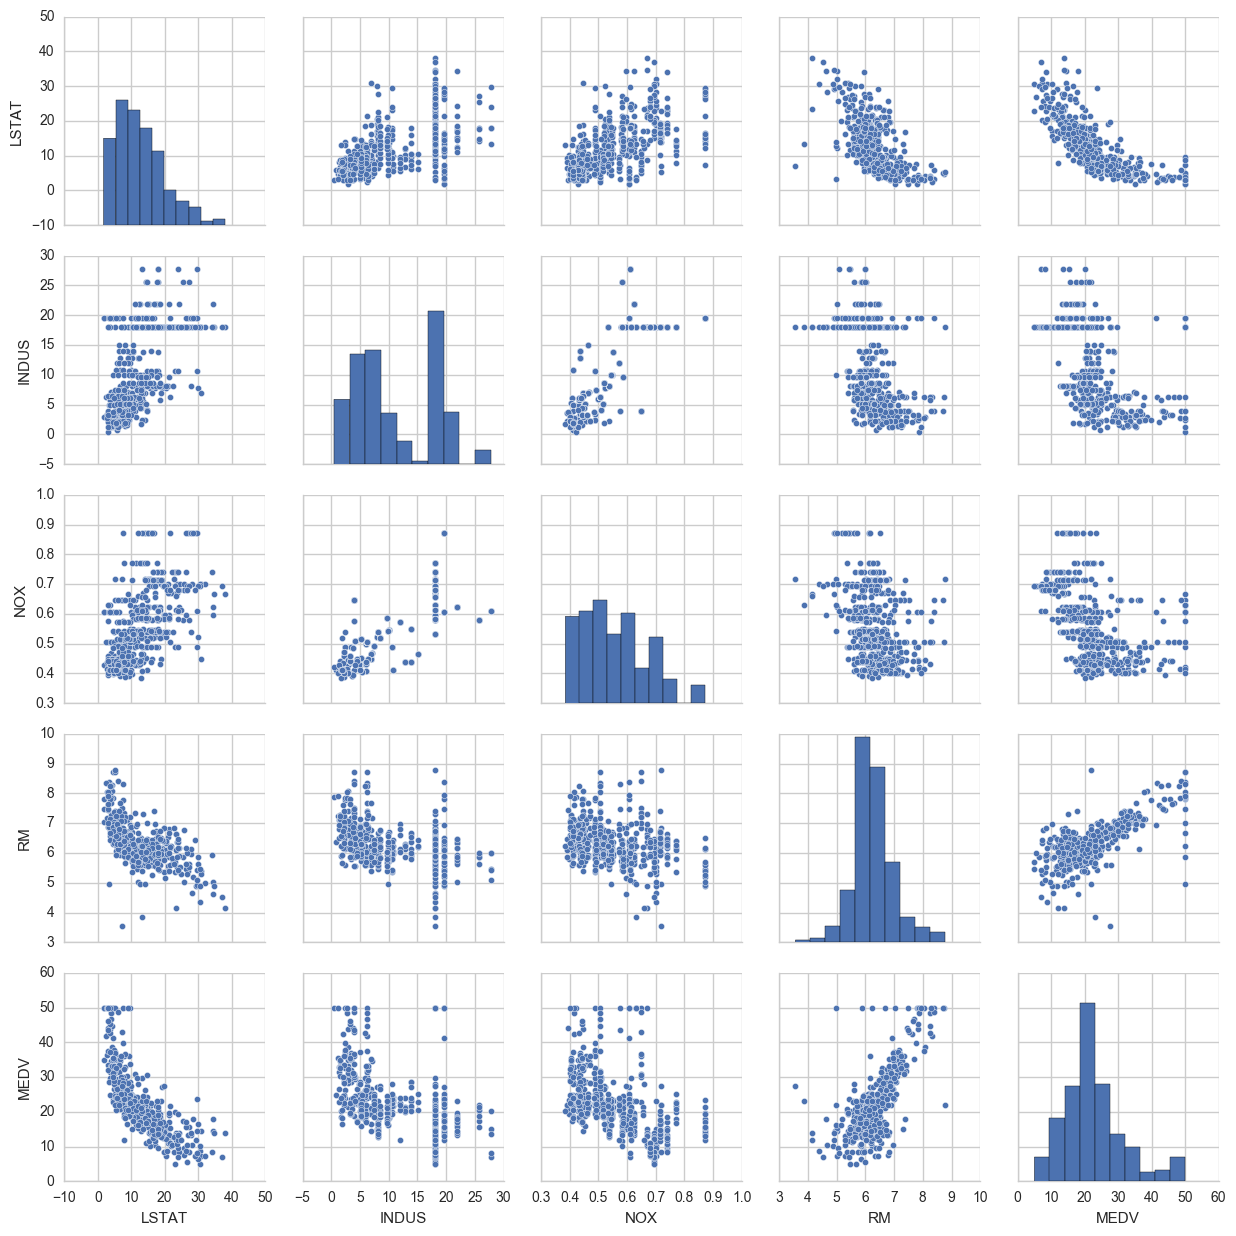

In [28]:
sns.set(style='whitegrid',context='notebook')
cols=['LSTAT','INDUS','NOX','RM','MEDV']
sns.pairplot(bos[cols],size=2.5)
plt.show()

Some things to note: 'RM' is the average number of rooms per dwelling. Unsurprisingly, there is a positive linear relationship between RM and MEDV.

LSTAT is the percentage lower status of the population. Here there is an inverse relationship with MEDV.

We can also see that MEDV is roughly normally distrubuted, but with some outliers.

### A correlation matrix to quantify linear relaionship between the features

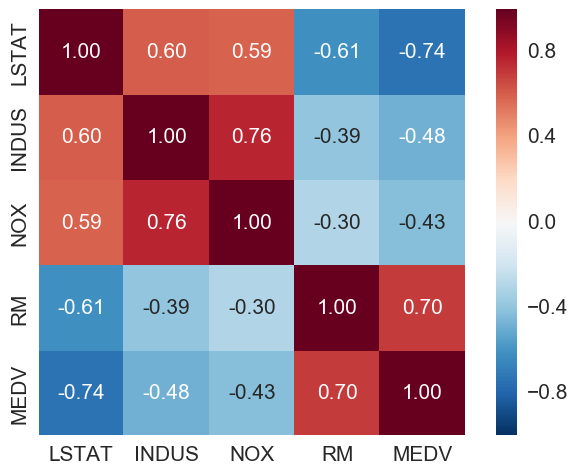

In [37]:
cm = np.corrcoef(bos[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':15},
                yticklabels=cols,
                xticklabels=cols)
plt.show()

### Looking more closely at some of the features...

#### Price vs RM
Price increases linearly with number of rooms, but there are some notable outliers.

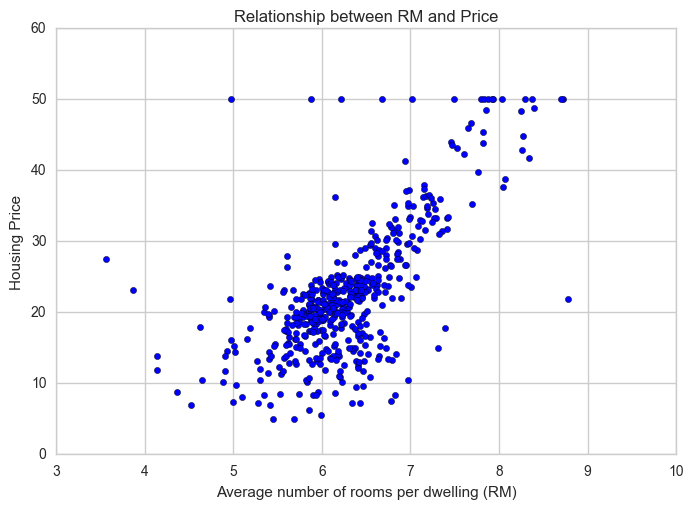

In [30]:
# Plot price vs average number of rooms
plt.scatter(bos.RM, bos.MEDV)
plt.xlabel("Average number of rooms per dwelling (RM)")
plt.ylabel("Housing Price")
plt.title("Relationship between RM and Price")

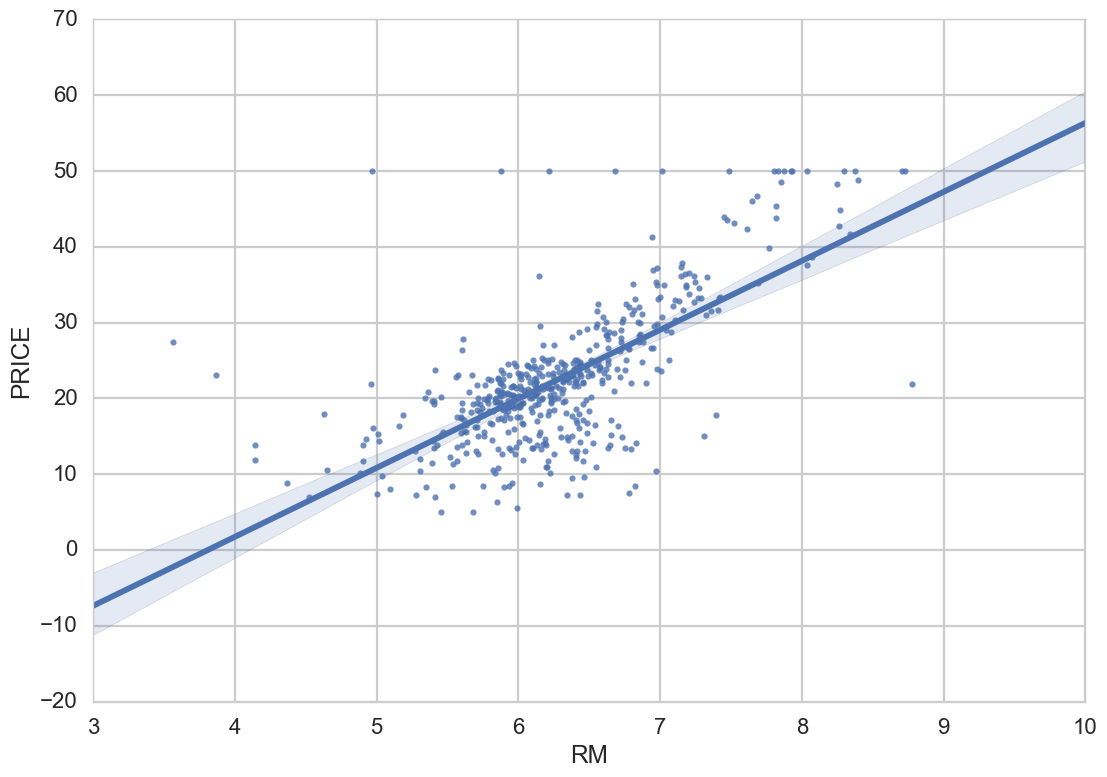

In [20]:
# Using seaborn regplot provides automatic linear regression fits
sns.regplot(y="MEDV", x="RM", data=bos, fit_reg = True)

#### Price vs Crime Rate

Most houses are in a low-crime rate town. Of the low crime towns, there is a lot of variation in housing prices. However, of the houses that are in a high-crime rate town, prices tend to be on the low end.

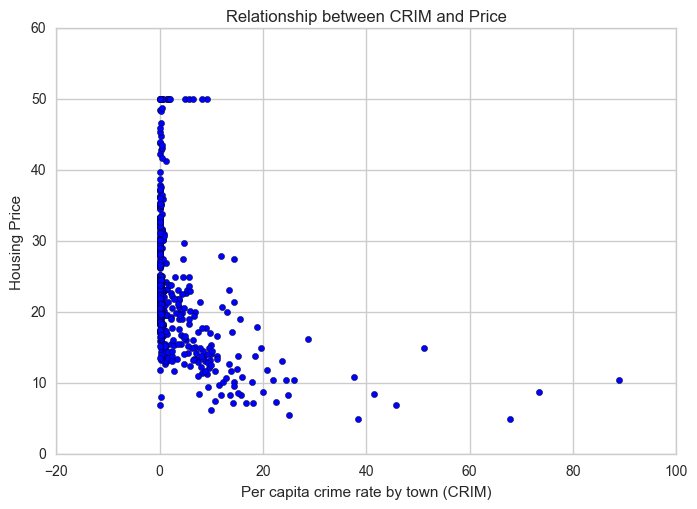

In [32]:
# How price varies as a function of per capita crime rate
plt.scatter(bos.CRIM, bos.MEDV)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Housing Price")
plt.title("Relationship between CRIM and Price")

#### Price vs Nitric Oxide Concentrations

Nitric oxide is an air pollutant generated by cars.

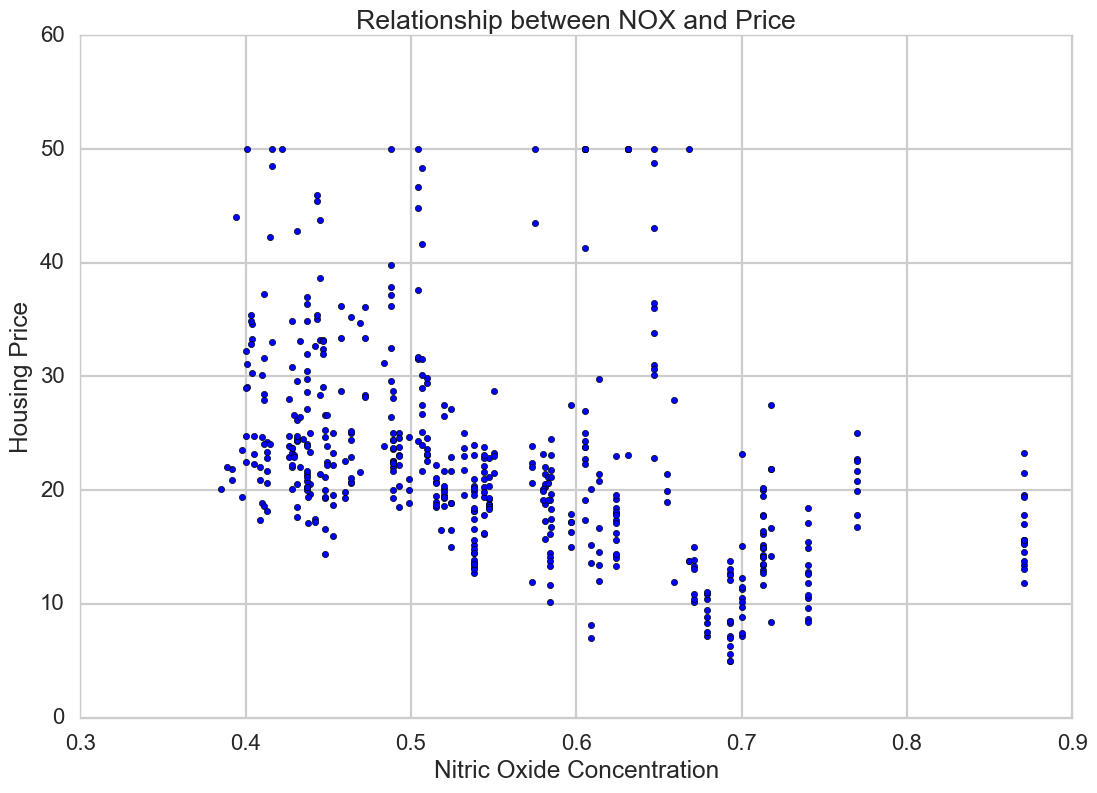

In [72]:
plt.scatter(bos.NOX, bos.MEDV)
plt.xlabel("Nitric Oxide Concentration")
plt.ylabel("Housing Price")
plt.title("Relationship between NOX and Price")

#### Price vs percentage lower status

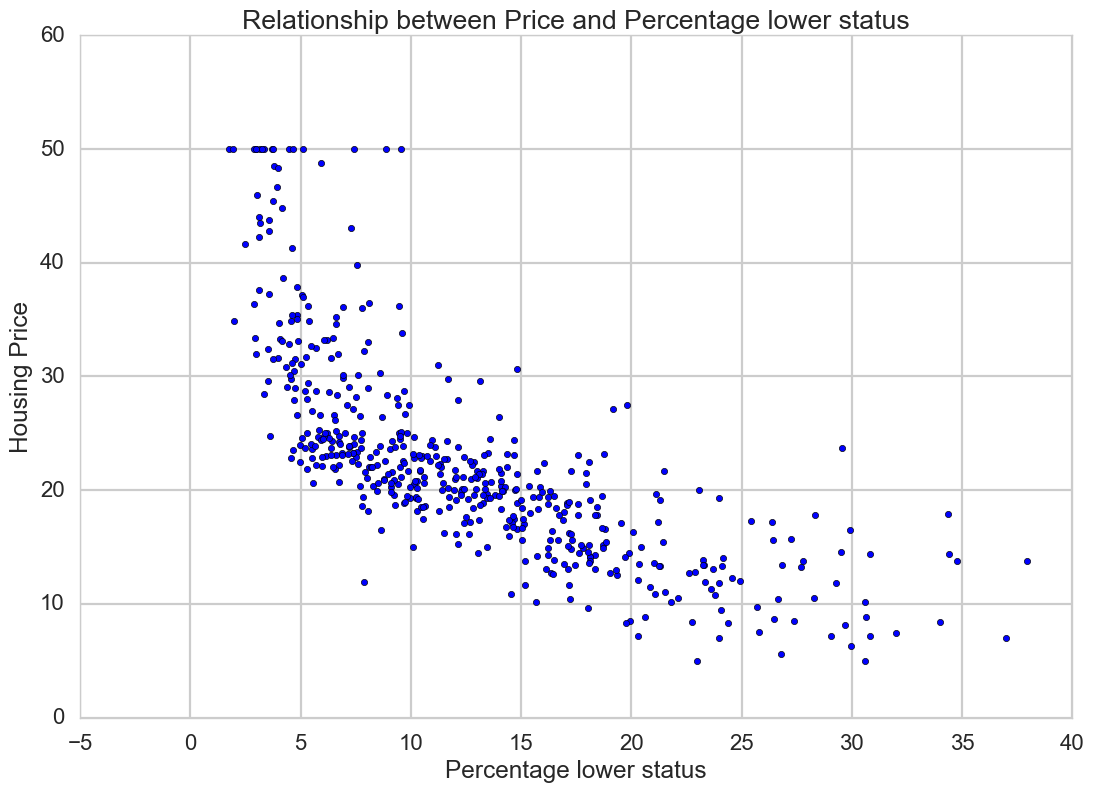

In [104]:
plt.scatter(bos.LSTAT, bos.MEDV)
plt.xlabel("Percentage lower status")
plt.ylabel("Housing Price")
plt.title("Relationship between Price and Percentage lower status")

Let's fit linear, quadratic, and cubic polynomial models.

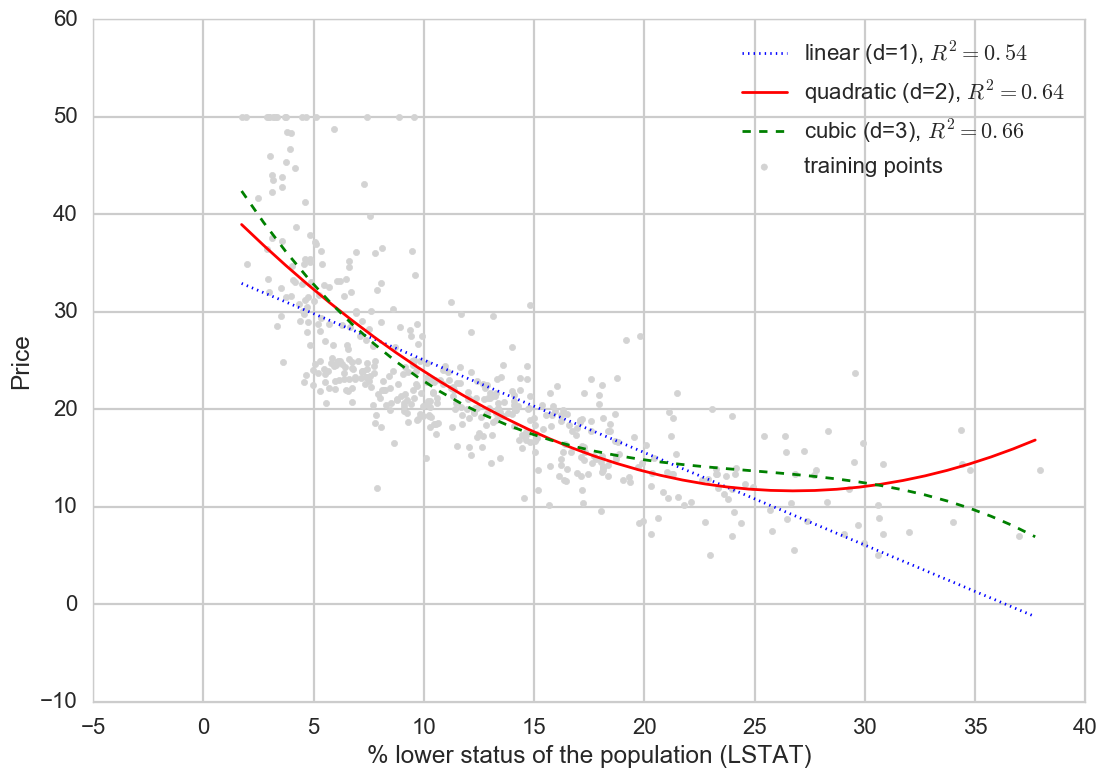

In [105]:
L = bos[['LSTAT']].values
y = bos['MEDV'].values
regr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
L_quad = quadratic.fit_transform(L)
L_cubic = cubic.fit_transform(L)

# linear fit
L_fit = np.arange(L.min(), L.max(), 1)[:, np.newaxis]
regr = regr.fit(L,y)
y_lin_fit = regr.predict(L_fit)
linear_r2 = r2_score(y, regr.predict(L))

# quadratic fit
regr = regr.fit(L_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(L_fit))
quadratic_r2 = r2_score(y, regr.predict(L_quad))

# cubic fit
regr = regr.fit(L_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(L_fit))
cubic_r2 = r2_score(y, regr.predict(L_cubic))

#Plot results
plt.scatter(L, y,
           label='training points',
           color='lightgray')
plt.plot(L_fit, y_lin_fit,
        label='linear (d=1), $R^2=%.2f$'
        % linear_r2,
        color='blue',
        lw=2,
        linestyle=':')
plt.plot(L_fit, y_quad_fit,
        label='quadratic (d=2), $R^2=%.2f$'
        % quadratic_r2,
        color='red',
        lw=2,
        linestyle='-')
plt.plot(L_fit, y_cubic_fit,
        label='cubic (d=3), $R^2=%.2f$'
        % cubic_r2,
        color='green',
        lw=2,
        linestyle='--')
plt.xlabel('% lower status of the population (LSTAT)')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.show()

Here a log transform of the LSTAT feature and taking the sq root of the price would project the data onto a linear feature space. 

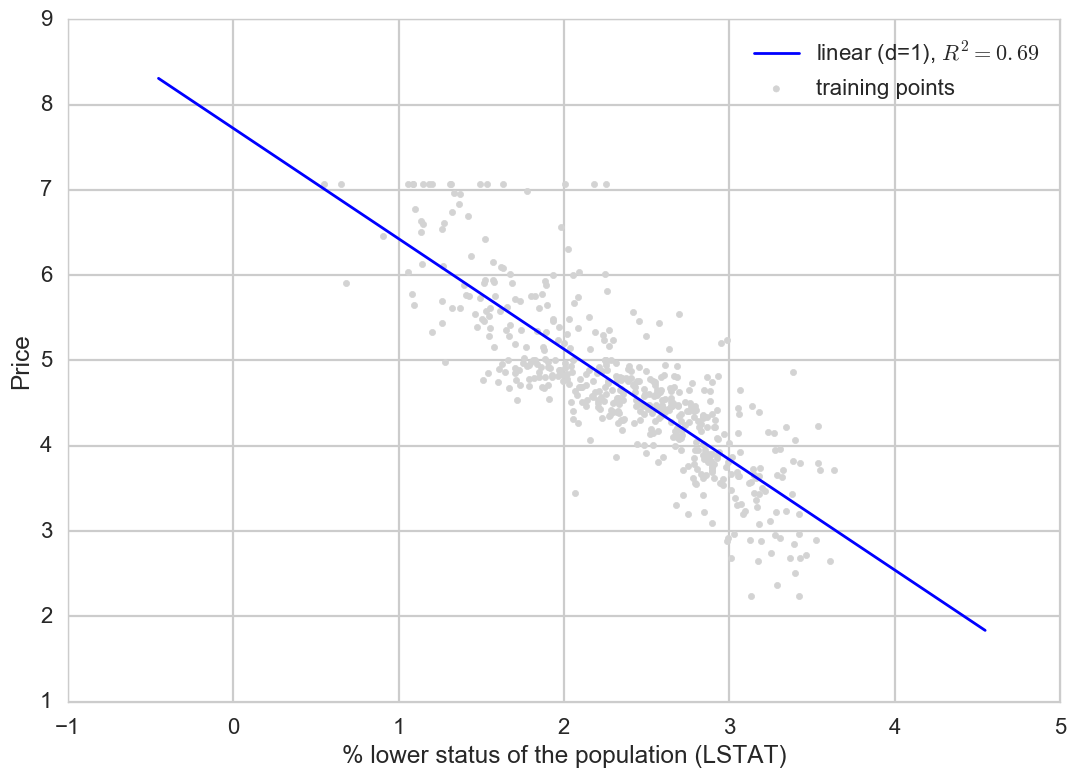

In [106]:
# Transform features
L_log = np.log(L)
y_sqrt = np.sqrt(y)

# Fit features
L_fit = np.arange(L_log.min()-1, L_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(L_log, y_sqrt)
y_lin_fit = regr.predict(L_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(L_log))

# Plot
plt.scatter(L_log, y_sqrt,
           label='training points',
           color='lightgray')
plt.plot(L_fit, y_lin_fit,
        label='linear (d=1), $R^2=%.2f$'
        % linear_r2,
        color='blue',
        lw=2)

plt.xlabel('% lower status of the population (LSTAT)')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.show()

### Fitting multiple regression models

In [64]:
# Using all features
X = bos.drop('MEDV', axis=1)

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.3, random_state = 0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

#### Plotting residuals

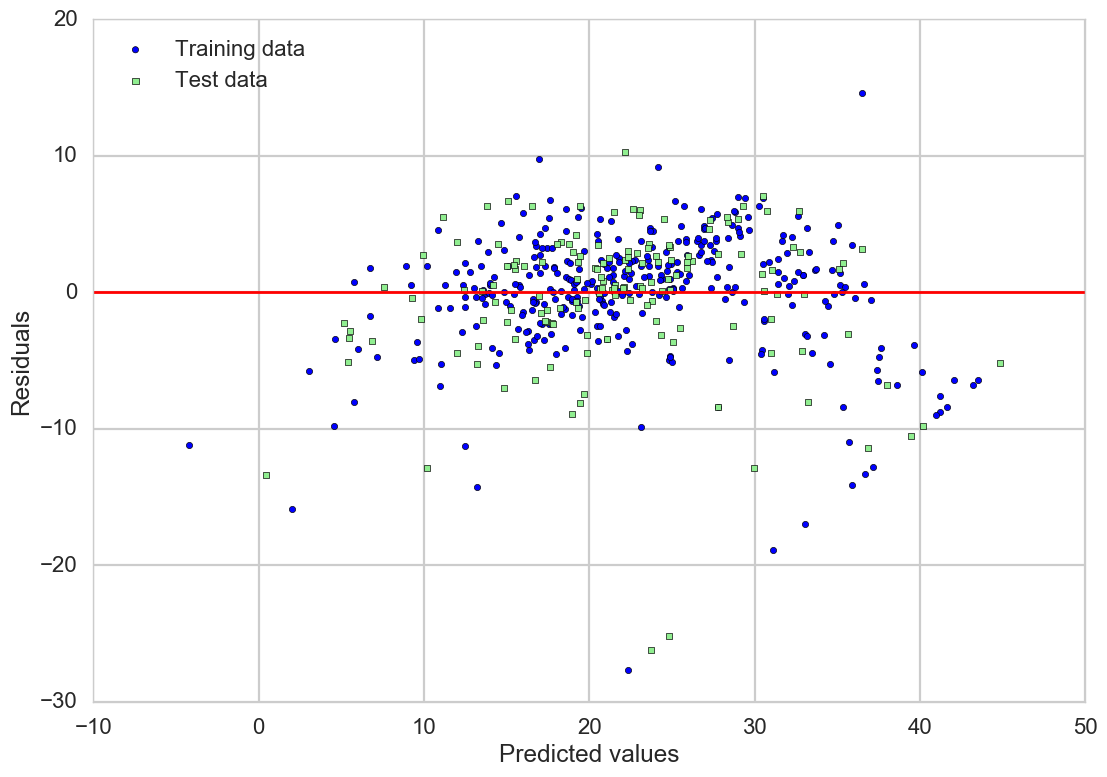

In [77]:
plt.scatter(y_train_pred, y_train_pred-y_train,
           c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred-y_test,
           c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10,50])
plt.show()

The errors are randomly distributed, and the residuals are randonly scattered around the centerline (we could also use this to pick out outliers)

#### Coefficients

In [103]:
pd.DataFrame(list(zip(X.columns, slr.coef_)), columns = ['features', 'estimatedCoefficients (ridge)'])

,features,estimatedCoefficients (ridge)
0,CRIM,-0.121310
1,ZN,0.044466
2,INDUS,0.011342
3,CHAS,2.511246
4,NOX,-16.231253
5,RM,3.859068
6,AGE,-0.009985
7,DIS,-1.500270
8,RAD,0.242143
9,TAX,-0.011072


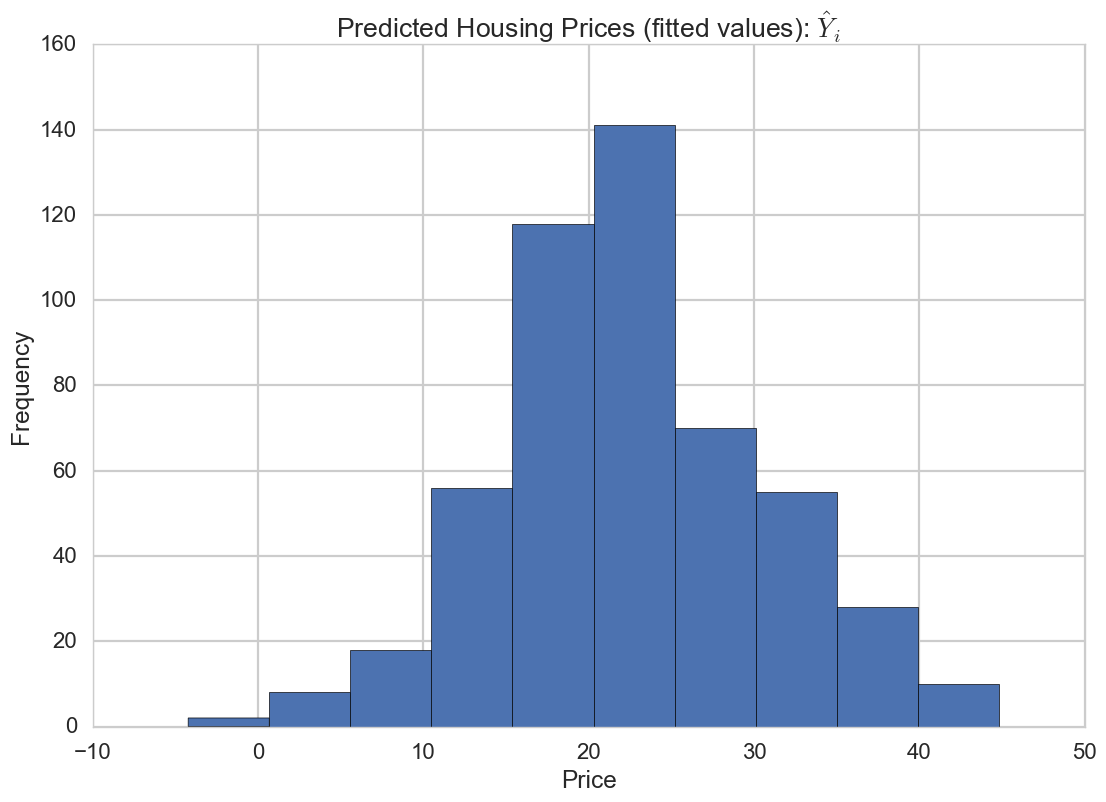

In [90]:
# The distribution of predicted prices
plt.hist(slr.predict(X))
plt.title('Predicted Housing Prices (fitted values): $\hat{Y}_i$')
plt.xlabel('Price')
plt.ylabel('Frequency')

#### MSE

In [86]:
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
    (r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred))))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


The MSE of the test set is a lot higher than the train's MSE- the model is overfitting.

#### Plotting predicted prices vs prices:

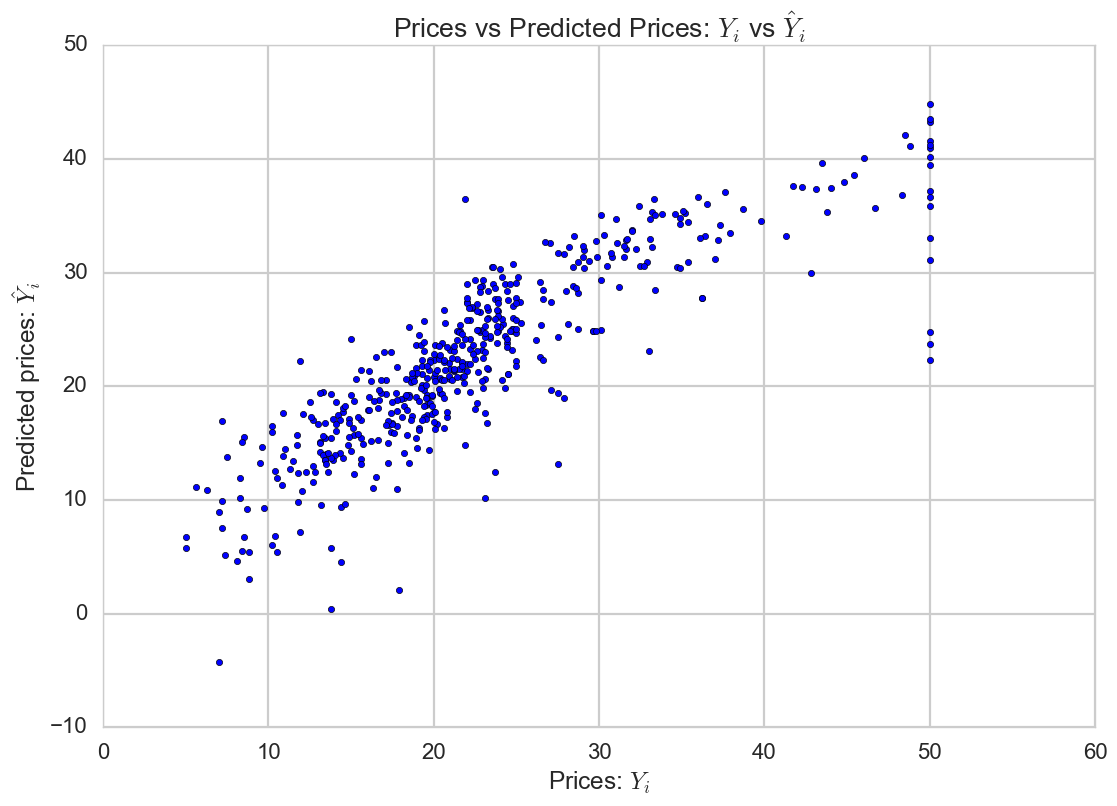

In [94]:
plt.scatter(bos.MEDV, slr.predict(X))
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted Prices: $Y_i$ vs $\hat{Y}_i$")

Also let's look at predicted prices vs. prices:
Perfect prediction would lead to a diagonal line. Here we see that the model does worse for the higher prices.

In [ ]:
'''
# Code for a robust regression model

ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,
                        min_samples=50,
                        residual_metric=lambda x: np.sum(np.abs(x), axis=1),
                        residual_threshold=5.0,
                        random_state=0)

ransac.fit(X_train, y_train)
y_train_pred_r = ransac.predict(X_train)
y_test_pred_r = ransac.predict(X_test)
'''

#### Regularized linear regression models

In [101]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_train_pred_l2 = ridge.predict(X_train)
y_test_pred_l2 = ridge.predict(X_test)

lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_train_pred_l1 = lasso.predict(X_train)
y_test_pred_l1 = lasso.predict(X_test)

EN = ElasticNet(alpha=1.0,l1_ratio=.5)
EN.fit(X_train, y_train)
y_train_pred_en = EN.predict(X_train)
y_test_pred_en = EN.predict(X_test)

In [102]:
print('MSE train (L2): %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred_l2),
    mean_squared_error(y_test, y_test_pred_l2)))
print('R^2 train (L2): %.3f, test: %.3f' % (
    (r2_score(y_train, y_train_pred_l2),
    r2_score(y_test, y_test_pred_l2))))

print('MSE train (L1): %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred_l1),
    mean_squared_error(y_test, y_test_pred_l1)))
print('R^2 train (L1): %.3f, test: %.3f' % (
    (r2_score(y_train, y_train_pred_l1),
    r2_score(y_test, y_test_pred_l1))))

print('MSE train (EN): %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred_en),
    mean_squared_error(y_test, y_test_pred_en)))
print('R^2 train (EN): %.3f, test: %.3f' % (
    (r2_score(y_train, y_train_pred_en),
    r2_score(y_test, y_test_pred_en))))

MSE train (L2): 20.145, test: 27.762
R^2 train (L2): 0.762, test: 0.667
MSE train (L1): 24.717, test: 32.345
R^2 train (L1): 0.708, test: 0.612
MSE train (EN): 24.381, test: 31.874
R^2 train (EN): 0.712, test: 0.617


Comparing with the unregularized model (not much better)

In [82]:
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
    (r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred))))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


## Random forest regression

In [109]:
# Using all the features
X = bos.iloc[:, :-1].values
y = bos['MEDV'].values

forest = RandomForestRegressor(n_estimators=1000,
                              criterion='mse',
                              random_state=1,
                              n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred_for = forest.predict(X_train)
y_test_pred_for = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred_for),
    mean_squared_error(y_test, y_test_pred_for)))
print('R^2 train: %.3f, test: %.3f' % (
    (r2_score(y_train, y_train_pred_for),
    r2_score(y_test, y_test_pred_for))))

MSE train: 1.409, test: 14.354
R^2 train: 0.983, test: 0.828


We are still overfitting but the R^2 is better than that of linear regression.

#### Residuals

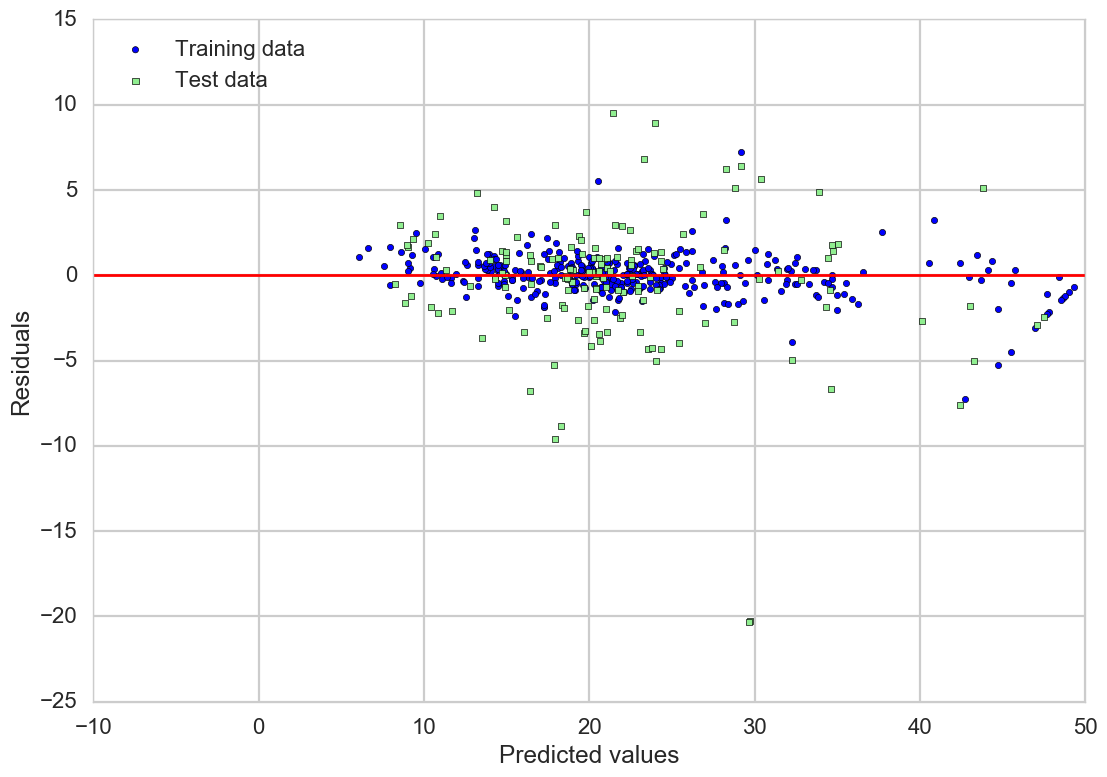

In [110]:
plt.scatter(y_train_pred_for, y_train_pred_for-y_train,
           c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred_for, y_test_pred_for-y_test,
           c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10,50])
plt.show()

This is an improvement over the linear model, although the model fits the training data better than the test data. Also the distribution of the residuals does not seem to be random, indicating that the model is not capturing all the exploratory information.

## Outliers

We saw here that there were some outliers in this dataset. Linear regression models are sensitive to outliers- we could get rid of them, though this requires making a judgment and/or domain knowledge, or we could use a robust regression model. 

I won't get rid of outliers here but let's look at how to predict outliers for illustration's sake.

#### Outlier detection methods
(Just looking at some of the features here.)

The empirical covariance (EllipticEnvelope) detects outliers in a Gaussian distributed dataset by fitting an ellipse around the central data points. It is highly sensitive to the heterogeneous structure of the data (it goes out of its way to fit several outliers).

The robust covariance (minimum covariance determinant) concentrates on the main mode of the data distribution (and also assumes the data is Gaussian distributed). It seems to work relatively well.

The OCSVM (One Class SVM) does unsupervised outlier detection; it does not assume any parametric form of the data distribution and can fit more complex shapes.

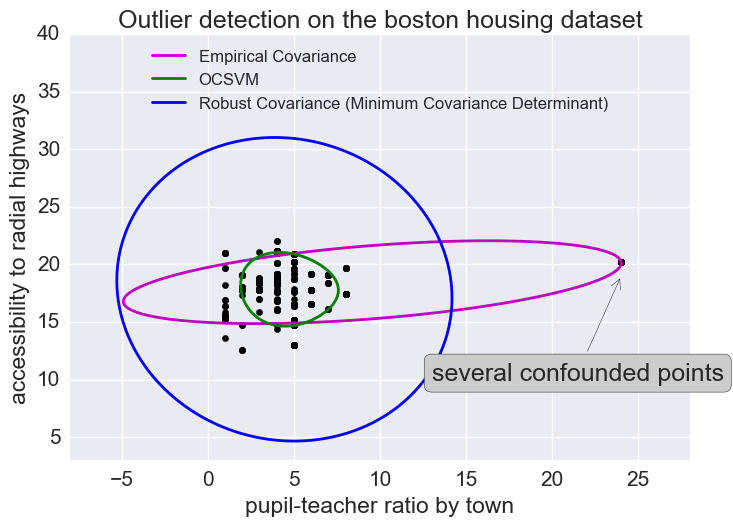

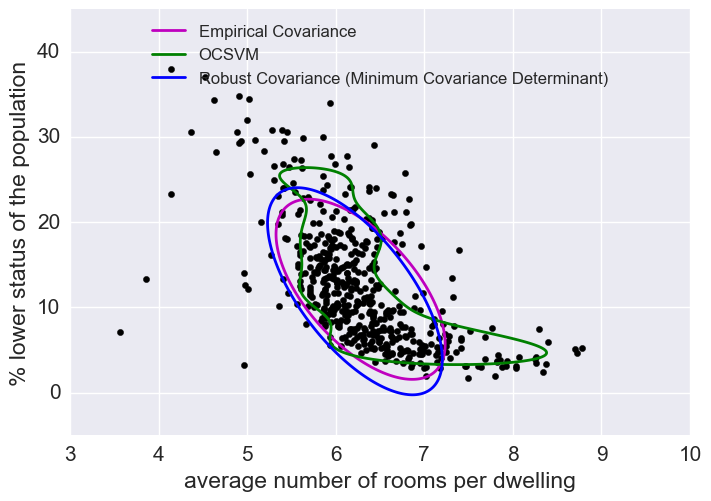

In [51]:
X1 = load_boston()['data'][:, [8, 10]]  # RAD & pupil-teacher-ratio: accessibility to radial highways
X2 = load_boston()['data'][:, [5, 12]]  # RM & LSAT: percent lower stats of the population

# Define "classifiers" to be used
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1., #support_fraction = the proportion of points to be included in the support of the estimate
                                             contamination=0.261),
    "Robust Covariance (Minimum Covariance Determinant)": EllipticEnvelope(contamination=0.261),
    "OCSVM": OneClassSVM(nu=0.261, gamma=0.05)}
colors = ['m', 'g', 'b']
legend1 = {}
legend2 = {}
#legend3 = {}

# Outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(-8, 28, 500), np.linspace(3, 40, 500))
xx2, yy2 = np.meshgrid(np.linspace(3, 10, 500), np.linspace(-5, 45, 500))
xx3, yy3 = np.meshgrid(np.linspace(-8, 28, 500), np.linspace(3, 40, 500))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    plt.figure(1)
    clf.fit(X1)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])
    
    plt.figure(2)
    clf.fit(X2)
    Z2 = clf.decision_function(np.c_[xx2.ravel(), yy2.ravel()])
    Z2 = Z2.reshape(xx2.shape)
    legend2[clf_name] = plt.contour(
        xx2, yy2, Z2, levels=[0], linewidths=2, colors=colors[i])
    '''
    plt.figure(3)
    clf.fit(X3)
    Z3 = clf.decision_function(np.c_[xx3.ravel(), yy3.ravel()])
    Z3 = Z3.reshape(xx3.shape)
    legend3[clf_name] = plt.contour(
        xx3, yy3, Z3, levels=[0], linewidths=2, colors=colors[i])
    '''
    
legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results 
plt.figure(1)  
plt.title("Outlier detection on the boston housing dataset")
plt.scatter(X1[:, 0], X1[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate("several confounded points", xy=(24, 19),
             xycoords="data", textcoords="data",
             xytext=(13, 10), bbox=bbox_args, arrowprops=arrow_args)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("accessibility to radial highways")
plt.xlabel("pupil-teacher ratio by town")

legend2_values_list = list(legend2.values())
legend2_keys_list = list(legend2.keys())

plt.figure(2)  # "banana" shape
plt.scatter(X2[:, 0], X2[:, 1], color='black')
plt.xlim((xx2.min(), xx2.max()))
plt.ylim((yy2.min(), yy2.max()))
plt.legend((legend2_values_list[0].collections[0],
            legend2_values_list[1].collections[0],
            legend2_values_list[2].collections[0]),
           (legend2_keys_list[0], legend2_keys_list[1], legend2_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("% lower status of the population")
plt.xlabel("average number of rooms per dwelling")

'''
legend3_values_list = list(legend3.values())
legend3_keys_list = list(legend3.keys())

plt.figure(3)  
plt.scatter(X3[:, 0], X3[:, 1], color='black')
plt.xlim((xx3.min(), xx3.max()))
plt.ylim((yy3.min(), yy3.max()))
plt.legend((legend3_values_list[0].collections[0],
            legend3_values_list[1].collections[0],
            legend3_values_list[2].collections[0]),
           (legend3_keys_list[0], legend3_keys_list[1], legend3_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("% lower status of the population")
plt.xlabel("average number of rooms per dwelling")
'''
plt.show()